# Classification d'images avec un réseau de neurones (pytorch)

Dans ce notebook on se propose de classifier des images à partir d'un réseau de neurones en utilisant la bibliothèque pytorch.

## Travail demandé :

Si vous n'êtes pas familiers avec pytorch, commencez par le tutoriel de prise en main, avant d'étudier le notebook ci-dessous.

Ensuite, vous devrez vous inspirer de ce tutoriel pour :
+ 1) Implémenter un exemple de réseau simple avec une couche cachée de 128 neurones et des activations `ReLU` pour classifier les images de la base mnist. (Complétez le notebook ci-dessous)
+ 2) Afficher l'évolution de la fonction de coût de l'ensemble de validation sur la même courbe que celle du coût sur l'ensemble d'entrainement. Y a-t-il surapprentissage ?
+ 3) Modifier le programme pour réduire le nombre d'images d'entrainement à 1000, et entrainez à nouveau votre modèle, en analysant les résultats d'entrainement, validation et test. Qu'observez-vous ?


### Imports python

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
%matplotlib inline

#Import pytorch:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split
import torchvision
import torchvision.transforms as transforms


/home/thmegy/anaconda3/envs/m2par_torch/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/thmegy/anaconda3/envs/m2par_torch/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## 1. Chargement et visualisation des données

On commence par charger nos données et les normaliser. Les données sont déjà séparées en une base d'entrainement et une base de test.

shape X train :  torch.Size([60000, 28, 28])
shape X test :  torch.Size([10000, 28, 28])
shape Y train :  torch.Size([60000])
shape Y test :  torch.Size([10000])


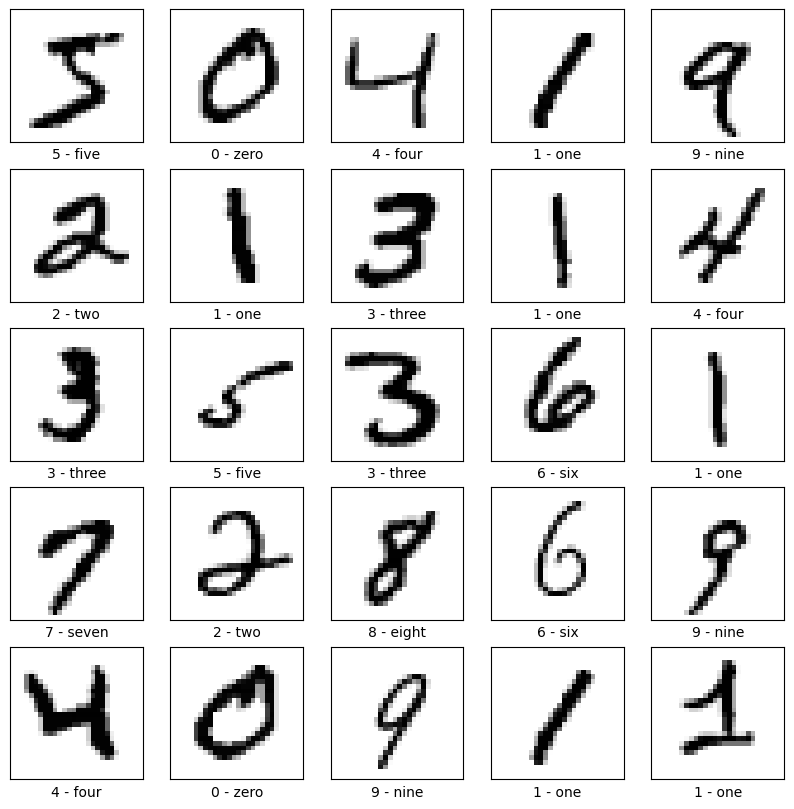

In [2]:
# Fonction de Normalisation pour passer de [0,1] vers [-1,1]]
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# Dataset
mnistTrainSet = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnistTestSet = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

X_train = mnistTrainSet.data/255
X_test = mnistTestSet.data/255
Y_train = mnistTrainSet.targets
Y_test = mnistTestSet.targets
class_names = mnistTrainSet.classes

print('shape X train : ', X_train.shape)
print('shape X test : ', X_test.shape)
print('shape Y train : ', Y_train.shape)
print('shape Y test : ', Y_test.shape)

# Affichage de quelques images et label associé
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[Y_train[i]])

Pour utiliser moins d'images on modifiera ici dans la question 3) :

In [3]:
# Nombre d'exemples considérés (vous pouvez changer ici !) :
n_train = 10000
n_test = 10000

# TODO : utiliser un Subset de n_train exemples
# Completer pour la Question 3)
# Pour utiliser un sous-ensemble du jeu d'entrainement
mnistTrainSubset = Subset(mnistTrainSet, torch.arange(n_train))

## 2. Construction du modèle 



### Modèle et prédictions

On définit notre réseau de neurones dans une classe spécifique ici. La fonction `forward` réalise notre propagation en avant, pour obtenir les probabilités prédites.

Note : **la rétropropagation n'a pas besoin d'être implémentée, elle sera calculée automatiquement par pytorch lors de l'appel de la fonction `backward`**

In [4]:
# Hyperparamètres
# Choisir ici le nombre de neurones de la couche cachée :

# Classe qui définit le réseau :
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            #nn.Softmax(dim=1)
        )     
        
    def forward(self, x):
        x = self.fc(x)
        return x
    
    
# Pour rendre les tirages aléatoires reproductibles (facultatif)   
torch.manual_seed(0)

# Création du réseau : 
model = Net()

# Affichage de l'architecture :
print(model)

Net(
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


## 3. Entrainement

### Préparation à l'entrainement


In [5]:
# Hyperparamètres
N_epochs = 25
batch_size = 100
learning_rate = 0.005

#### Choix de la fonction de coût
https://pytorch.org/docs/master/nn.html#loss-functions

In [6]:
loss_function = nn.CrossEntropyLoss()

#### Choix de l'optimiseur
https://pytorch.org/docs/master/optim.html#algorithms

In [7]:
# Choix de l'optimiseur
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate)

On sépare ici le Dataset de test en un ensemble de validation et un ensemble de test (uniquement pour la visualisation de l'évolution de la généralisation !) et on créé 3 dataloader

In [8]:
# Split test Dataset
mnistValset, mnistTestSet = random_split(mnistTestSet, 
                                                            [int(0.1 * len(mnistTestSet)), 
                                                             int(0.9 * len(mnistTestSet))])

# Outil de chargement des lots de données
mnistTrainLoader = DataLoader(mnistTrainSet, batch_size=batch_size,shuffle=True, num_workers=0)
mnistValLoader = DataLoader(mnistValset, batch_size=1000, shuffle=False, num_workers=0)
mnistTestLoader = DataLoader(mnistTestSet, batch_size=batch_size, shuffle=False, num_workers=0)

In [11]:
# Calcul de la loss de validation initiale
for features_val, labels_val in mnistValLoader: 
    labels_val_pred = model(features_val)
    val_loss = loss_function(labels_val_pred,labels_val)

    
print('Shape du tenseur de features de validation : ', features_val.shape)
print(val_loss)

Shape du tenseur de features de validation :  torch.Size([1000, 1, 28, 28])
tensor(2.3143, grad_fn=<NllLossBackward0>)


### Entrainement du réseau
L'exemple ci-dessous illustre une descente de gradient simple, mais on pourra également réaliser une descente de gradient stochastique en sélectionnant des lots de données.

In [185]:
# Nombre d'itérations
losses = []  
val_losses = []
i_list = []
i=0
for epoch in range(N_epochs):  # Boucle sur les époques   
    for features, labels in mnistTrainLoader:        
        
        #Propagation en avant
        pred = model(features)

        #Calcul du coût
        loss = loss_function(pred, labels)

        #on sauvegarde la loss pour affichage futur
        losses.append(loss.item())

        #Effacer les gradients précédents
        optimizer.zero_grad()        
        
        #Calcul des gradients (rétro-propagation)
        loss.backward()

        # Mise à jour des poids : un pas de l'optimiseur
        optimizer.step()
        
        i+=1
        
    with torch.no_grad():
        val_loss = []
        for features, labels in mnistValLoader:
            #Propagation en avant
            pred = model(features)

            #Calcul du coût
            loss = loss_function(pred, labels)

            #on sauvegarde la loss pour affichage futur
            val_loss.append(loss.item())
            
        val_losses.append(np.array(val_loss).mean())
        i_list.append(i)

        
    # print statistics
    print('[Epoque : %d] loss: %.3f' %
              (epoch + 1, loss.item()))
   
print('Entrainement terminé')

[Epoque : 1] loss: 0.476
[Epoque : 2] loss: 0.382
[Epoque : 3] loss: 0.321
[Epoque : 4] loss: 0.292
[Epoque : 5] loss: 0.234
[Epoque : 6] loss: 0.246
[Epoque : 7] loss: 0.237
[Epoque : 8] loss: 0.198
[Epoque : 9] loss: 0.235
[Epoque : 10] loss: 0.225
[Epoque : 11] loss: 0.283
[Epoque : 12] loss: 0.260
[Epoque : 13] loss: 0.213
[Epoque : 14] loss: 0.237
[Epoque : 15] loss: 0.265
[Epoque : 16] loss: 0.221
[Epoque : 17] loss: 0.262
[Epoque : 18] loss: 0.264
[Epoque : 19] loss: 0.251
[Epoque : 20] loss: 0.262
[Epoque : 21] loss: 0.315
[Epoque : 22] loss: 0.314
[Epoque : 23] loss: 0.255
[Epoque : 24] loss: 0.303
[Epoque : 25] loss: 0.305
Entrainement terminé


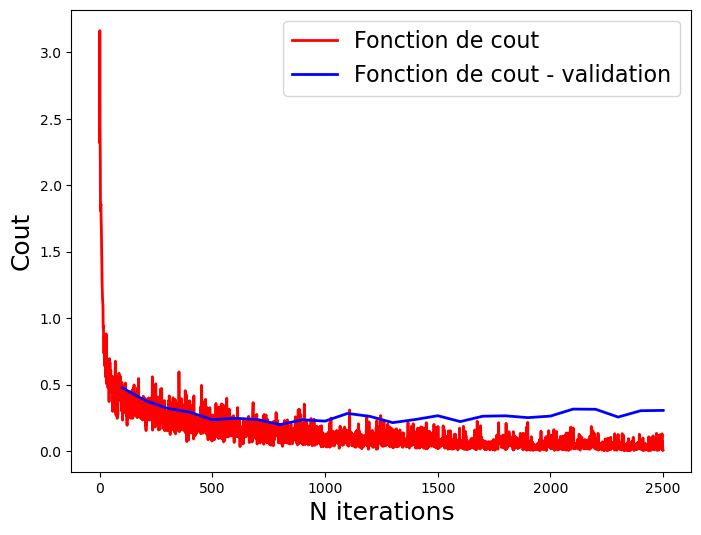

In [186]:
# Afficher l'évolution de la fonction de coût
fig, axes = plt.subplots(figsize=(8,6))
axes.plot(losses,'r-',lw=2,label='Fonction de cout')
axes.plot(i_list, val_losses,'b-',lw=2,label='Fonction de cout - validation')
axes.set_xlabel('N iterations',fontsize=18)
axes.set_ylabel('Cout',fontsize=18)
plt.legend(loc='upper right',fontsize=16)

## 5. Evaluation des performances

In [187]:
correct = 0
total = 0
# Pas besoin de calculer les gradient ici puisqu'on n'optimise plus
with torch.no_grad():
    for data in mnistTestLoader:
        images, labels = data
        # Propagation en avant pour calculer les prédictions
        outputs = model(images)         
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy sur les 10000 images de test : %d %%' % (
    100 * correct / total))

Accuracy sur les 10000 images de test : 93 %


## 6. Predictions

In [144]:
predictions = model(X_test.type(torch.FloatTensor))
print('shape predictions : ', predictions.shape)


shape predictions :  torch.Size([10000, 10])


In [188]:
X_test.type(torch.FloatTensor)

torch.Size([10000, 28, 28])

/tmp/ipykernel_213763/3731815188.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions_array, true_label, img = F.softmax(predictions_array[i]), true_label[i], img[i]
/tmp/ipykernel_213763/3731815188.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions_array, true_label = F.softmax(predictions_array[i]), true_label[i]


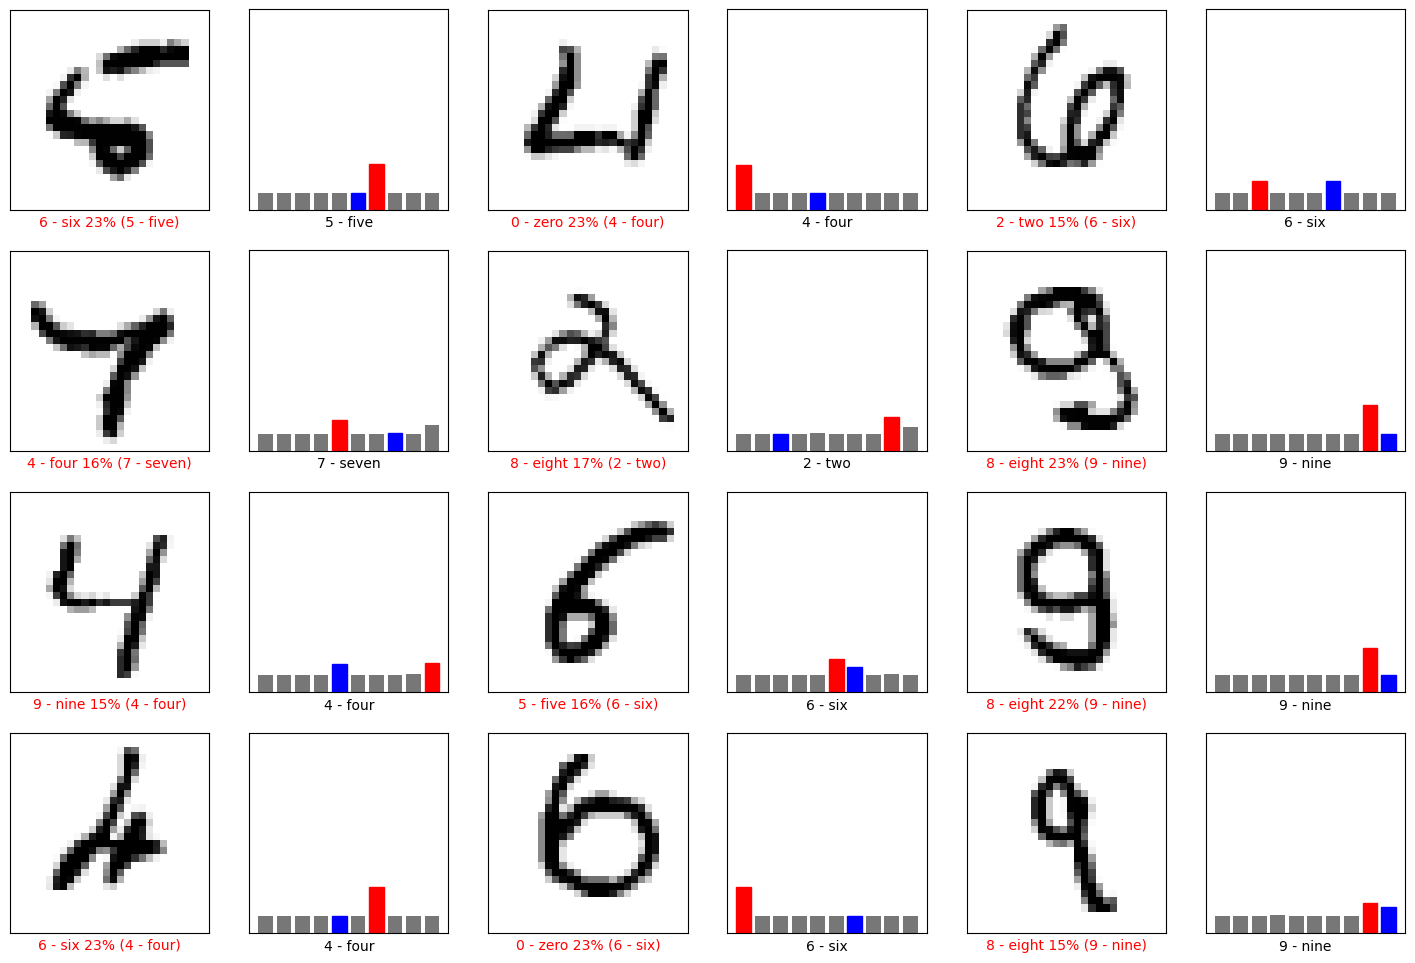

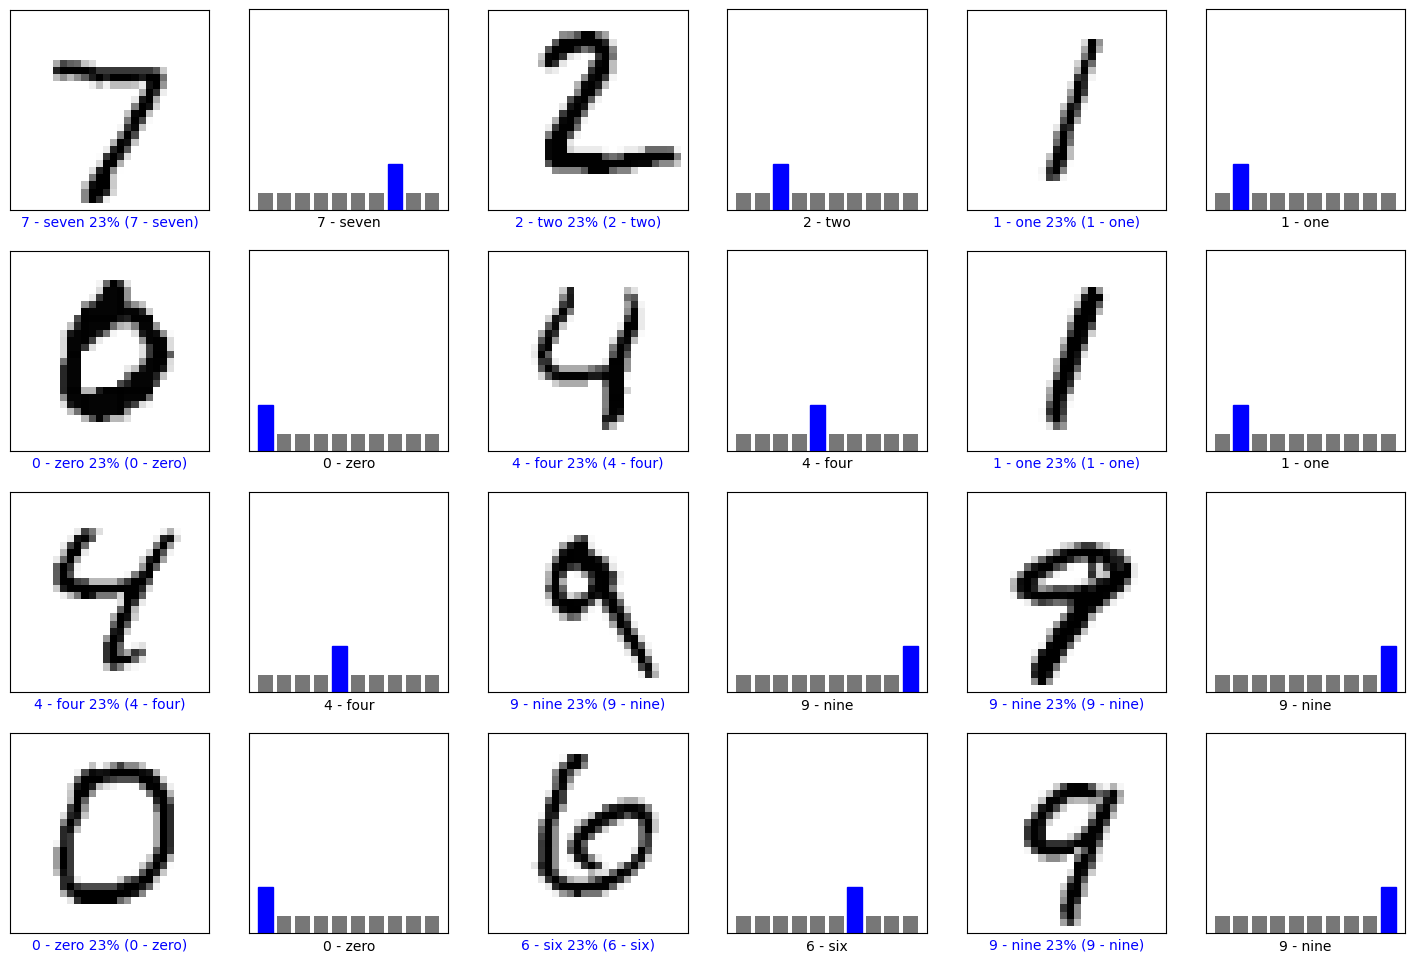

In [145]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = F.softmax(predictions_array[i]), true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])  
    plt.imshow(img, cmap=plt.cm.binary)  
    predicted_label = torch.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'  
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*torch.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = F.softmax(predictions_array[i]), true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array.detach(), color="#777777")
    plt.ylim([0, 1])
    predicted_label = torch.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


# Affichage de quelques images et de leurs prédictions 
_, predicted = torch.max(predictions.data, 1)
labels = Y_test
correct = (predicted == labels)
false = (predicted != labels)
    
# Affichage de quelques exemples d'erreurs
idx_false = np.where(false)
plt.figure(figsize=(18,12))
K=0
for i in idx_false[0][0:12]:  
    plt.subplot(4,6,2*K+1)
    plot_image(i, predictions, Y_test, X_test)
    plt.subplot(4,6,2*K+2)
    plot_value_array(i, predictions,  Y_test)
    plt.xlabel(class_names[Y_test[i]])
    K=K+1
plt.show()


# Affichage de quelques exemples de prédictions correctes
idx_correct = np.where(correct)
plt.figure(figsize=(18,12))
K=0
for i in idx_correct[0][0:12]:  
    plt.subplot(4,6,2*K+1)
    plot_image(i, predictions, Y_test, X_test)
    plt.subplot(4,6,2*K+2)
    plot_value_array(i, predictions,  Y_test)
    plt.xlabel(class_names[Y_test[i]])
    K=K+1
plt.show()